In [2]:
import pandas as pd
import upsetplot
from upsetplot import from_memberships
from upsetplot import plot
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
species_list = ['dmel', 'dsim', 'dana', 'dvir', 'sleb']

# read in the orthomcl file
orthomcl_file = 'groups_g.txt'
groups = pd.read_csv(orthomcl_file, sep=':', header=None, names=['cluster', 'group'])

# extract the species each group has
groups['species'] = groups['group'].apply(lambda x: ', '.join(dict.fromkeys(pd.Series(x.split()).str.extract(r'(\w+)\|')[0].dropna())) if x else None)

# create a new column for each species with the gene names
for species in ['dmel', 'dsim', 'dana', 'dvir', 'sleb']:
    groups[f'{species}_gene'] = (
        groups['group']
        .str.findall(fr'{species}\|(\S+)')  # Find all gene matches for the species
        .apply(lambda x: ','.join(x) if x else None)  # Convert list to comma-separated string
    )
# create a new column for each species with the count of genes in the species
for sp in species_list:
    col_name = sp + '_count'
    groups[col_name] = groups['group'].apply(lambda x: x.count(sp))


In [5]:
def species_counts(groups, bar=False, upset=False):
    
    # get the value counts of the species for each gene group
    species_counts = groups['species'].value_counts()
    species_dict = {tuple(k.split(', ')): v for k, v in species_counts.items()}

    # barplot
    if bar:
        plt.figure(figsize=(5, 5))
        ax = sns.barplot(x=species_counts.index, y=species_counts.values)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        fig = ax.get_figure()
        #fig.savefig("hist.pdf", dpi=300, bbox_inches="tight")


    # plot upset plot for genes shared by all species for existence
    if upset:
        membership_list = [list(k) for k in species_dict.keys()]
        count_values = list(species_dict.values())

        example = from_memberships(membership_list, data=count_values)

        import matplotlib as mpl
        new_rc_params = {'text.usetex': False,
        "svg.fonttype": 'none'
        }
        mpl.rcParams.update(new_rc_params)

        plt.rcParams['font.family'] = 'Arial'

        fig = plt.figure(figsize=(3, 3)) # set size of the figure
        plot_result = plot(example, fig=fig, element_size=10, sort_by='cardinality', sort_categories_by='-cardinality') # plot and sort the categories
        plt.suptitle("Conservation of all genes across species", size=8) # add title

        # the upset plot is consists of 3 parts: intersections, matrix and totals.
        plot_result["intersections"].set_ylabel("Count", fontsize=8)
        plot_result["intersections"].tick_params(labelsize=7)
        plot_result["totals"].set_xlabel("Genes in species", size=8)
        plot_result["matrix"].tick_params(axis='y', labelsize=7)
        plot_result["totals"].tick_params(labelsize=7)

        #plt.savefig("species_group_0221_2.svg", dpi=300)

/Users/cong/opt/anaconda3/envs/research_py39/lib/python3.9/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/cong/opt/anaconda3/envs/research_py39/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original objec

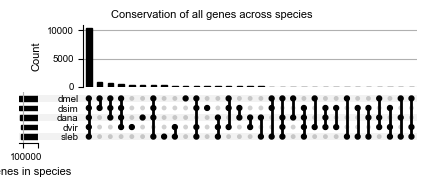

In [6]:
species_counts(groups, bar=False, upset=True)

In [15]:
# Load expression(TPM) data for each species
dmel_ex = pd.read_csv('ef_TPM/Dmel_comb_TPM.txt', sep='\t', header=0)
dsim_ex = pd.read_csv('ef_TPM/Dsim_comb_TPM.txt', sep='\t', header=0)
dana_ex = pd.read_csv('ef_TPM/Dana_comb_TPM.txt', sep='\t', header=0)
dvir_ex = pd.read_csv('ef_TPM/Dvir_comb_TPM.txt', sep='\t', header=0)
sleb_ex = pd.read_csv('ef_TPM/Sleb_comb_TPM.txt', sep='\t', header=0)

# calculate mean expression of bacteria infection
for df in [dmel_ex, dsim_ex, dana_ex, dvir_ex, sleb_ex]: 
    df['bac_mean'] = df.iloc[:, -3:].mean(axis=1)

# remove 'gene-' prefix from gene IDs in non-mel species
for species in ['dsim', 'dana', 'dvir', 'sleb']: 
    globals()[f'{species}_ex']['Gene ID'] = globals()[f'{species}_ex']['Gene ID'].str.replace(r'gene-', '', regex=True)


# Load result tables for each species
dmel_res = pd.read_csv('ef_result_v2/dmel_res_table_ef_tb.txt', sep=' ', header=0)
dsim_res = pd.read_csv('ef_result_v2/dsim_res_table_ef_tb.txt', sep=' ', header=0)
dana_res = pd.read_csv('ef_result_v2/dana_res_table_ef_tb.txt', sep=' ', header=0)
dvir_res = pd.read_csv('ef_result_v2/dvir_res_table_ef_tb.txt', sep=' ', header=0)
sleb_res = pd.read_csv('ef_result_v2/sleb_res_table_ef_tb.txt', sep=' ', header=0)

# remove 'gene-' prefix
for species in ['dsim', 'dana', 'dvir', 'sleb']:
    globals()[f'{species}_res']['gene'] = globals()[f'{species}_res']['gene'].str.replace(r'gene-', '', regex=True)

In [22]:
# get genes shared by all species
gene_shared_all = groups[groups['species']=='dmel, dsim, dana, dvir, sleb']
gene_shared_all_1 = gene_shared_all[gene_shared_all.iloc[:, -5:].eq(1).all(axis=1)]

# extract gene names
gene_shared_all_1[['dmel_gene', 'dsim_gene', 'dana_gene', 'dvir_gene', 'sleb_gene']] = (
    gene_shared_all_1['group']
    .str.extract(r'dmel\|(\S+).*dsim\|(\S+).*dana\|(\S+).*dvir\|(\S+).*sleb\|(\S+)')
)

# merge expression data and result data to dataframe for each species
for species, exp_df, res_df in zip(species_list, 
                                  [dmel_ex, dsim_ex, dana_ex, dvir_ex, sleb_ex], 
                                  [dmel_res, dsim_res, dana_res, dvir_res, sleb_res]):
    exp_df = exp_df.drop_duplicates(subset=['Gene ID'])
    res_df = res_df.drop_duplicates(subset=['gene'])
    # Merge expression data (bac_mean)
    gene_shared_all_1 = gene_shared_all_1.merge(
        exp_df[['Gene ID', 'bac_mean']], 
        left_on=f'{species}_gene', 
        right_on='Gene ID', 
        how='left'
    ).rename(columns={'bac_mean': species}).drop(columns=['Gene ID'])

    # Merge log2FoldChange data and rename it
    gene_shared_all_1 = res_df[['gene', 'log2FoldChange', 'gene_category']].merge(
        gene_shared_all_1, 
        left_on='gene', 
        right_on=f'{species}_gene', 
        how='right'
    ).rename(columns={'log2FoldChange': f'{species}_fold', 'gene_category': f'{species}_cat'}).drop(columns=['gene'])

/var/folders/jt/wf6lflrs1_94wjjrq_r5mrvm0000gn/T/ipykernel_68827/421411186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_shared_all_1[['dmel_gene', 'dsim_gene', 'dana_gene', 'dvir_gene', 'sleb_gene']] = (


In [23]:
gene_shared_all_1.to_csv('gene_shared_all_1_pr.csv')

In [88]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

mpl.rcParams["font.family"] = "Arial"

npg_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF"]
npg_palette2 = ["#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
sns.set_palette(npg_palette)

sns.set_style('white', {'axes.linewidth': 0.85})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [89]:
def plot_expression_all(gene_shared_all_1):
    # melt the DataFrame to long format
    gene_shared_all_1_long = pd.melt(
        gene_shared_all_1, 
        id_vars=['group'],  # Keep 'group' as an identifier (optional)
        value_vars=['dmel', 'dsim', 'dana', 'dvir', 'sleb'],  # Species columns
        var_name='species', 
        value_name='bac_mean'  # Values go into this column
    )

    ## KDE plot
    plt.figure(figsize=(2.5, 2))
    ax = sns.kdeplot(data=gene_shared_all_1_long, x='bac_mean', hue='species', fill=False, lw=0.75, bw_adjust=3, legend=True)

    plt.xlim(0, 1000)

    plt.title("Expression of shared genes", size=8)
    plt.tick_params(labelsize=7)
    plt.xlabel("TPM", size=8)
    plt.ylabel("Frequency", size=8)

    ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title="Species", fontsize=7, title_fontsize=8, markerscale=0.8, 
                    frameon=False)
    sns.despine() # remove top and right spines

    plt.tight_layout()
    #plt.show()
    #plt.savefig("expression_shared_genes.svg", dpi=300)


    ## violin plot
    plt.figure(figsize=(2, 2))
    ax = sns.violinplot(data=gene_shared_all_1_long, x='species', y='bac_mean', cut=0, palette=npg_palette, linewidth=0.1)
    #plt.ylim(-5,300)
    #plt.ylim(500,15000)

    plt.title("Expression of shared genes", size=8)
    plt.xlabel("Species", size=8)
    plt.ylabel("TPM", size=8)
    ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
    sns.despine() # remove top and right spines

    plt.tight_layout()
    #plt.show()
    #plt.savefig("expression_shared_genes_violin_cut0.svg", dpi=300)#, bbox_inches='tight')   


    ## violin plot with zoom in
    plt.figure(figsize=(2, 2))
    ax = sns.violinplot(data=gene_shared_all_1_long, x='species', y='bac_mean', cut=0, palette=npg_palette, linewidth=0.5)
    plt.ylim(-5,300)
    #plt.ylim(500,15000)

    plt.title("Expression of shared genes", size=8)
    plt.xlabel("Species", size=8)
    plt.ylabel("TPM", size=8)
    ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
    sns.despine() # remove top and right spines

    plt.tight_layout()
    #plt.show()
    #plt.savefig("expression_shared_genes_violin_low_cut0.svg", dpi=300)#, bbox_inches='tight')

/var/folders/jt/wf6lflrs1_94wjjrq_r5mrvm0000gn/T/ipykernel_3494/3182443556.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=gene_shared_all_1_long, x='species', y='bac_mean', cut=0, palette=npg_palette, linewidth=0.1)
/var/folders/jt/wf6lflrs1_94wjjrq_r5mrvm0000gn/T/ipykernel_3494/3182443556.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=gene_shared_all_1_long, x='species', y='bac_mean', cut=0, palette=npg_palette, linewidth=0.5)


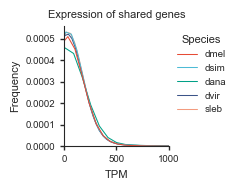

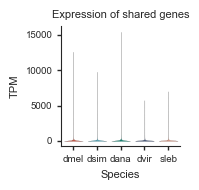

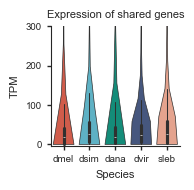

In [90]:
plot_expression_all(gene_shared_all_1)

In [104]:
upregulated = {}
for sp in species_list[:]:
        dmel_up = gene_shared_all_1[gene_shared_all_1[f'{sp}_cat']=='Upregulated']
        upregulated[sp] = dmel_up
        dmel_up['dmel_gene'].to_csv(f'{sp}_upregulated_dmel_genes.txt', index=False, header=False)

In [105]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def plot_upregulated_genes(gene_shared_all_1, species_list):
    for sp in species_list[:]:        
        # remove rows with fold changes = NA
        up = upregulated[sp]
        up = up.dropna(subset=['dmel_fold', 'dsim_fold', 'dana_fold', 'dvir_fold', 'sleb_fold'])
        
        #print(dmel_up[['dmel_fold', 'dsim_fold', 'dana_fold', 'dvir_fold', 'sleb_fold']].describe())

        up_long = pd.melt(
            up, 
            #value_vars=['dmel', 'dsim', 'dana', 'dvir', 'sleb'],  # Species columns
            value_vars=['dmel_fold', 'dsim_fold', 'dana_fold', 'dvir_fold', 'sleb_fold'], 
            var_name='species', 
            value_name='fold_change'  # Values go into this column
        )
        dmel_up_long['species'] = dmel_up_long['species'].str.replace('_fold', '', regex=False)
        
        #dmel_up_long = dmel_up_long[dmel_up_long["fold_change"] > 100]
        
        plt.figure(figsize=(2, 2))
        ax = sns.violinplot(data=dmel_up_long, x='species', y='fold_change', cut=0, hue='species', legend=False, 
                            palette=npg_palette, linewidth=0.5)
        #plt.ylim(-5,15)
        
        plt.title(f"Upregulated genes in {sp}", size=8)
        plt.xlabel("Species", size=8)
        plt.ylabel("Log2 fold change", size=8)
        
        from matplotlib.ticker import MultipleLocator
        plt.gca().yaxis.set_major_locator(MultipleLocator(5))  # Every 2 units on y-axis
        
        ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
        sns.despine() # remove top and right spines
        
        plt.tight_layout()

        # statistical analysis
        p_values = []
        for i in range(len(species_list)):
            for j in range(i + 1, len(species_list)):
                species1 = species_list[i]
                species2 = species_list[j]
                
                group1 = dmel_up_long[dmel_up_long['species'] == species1]['fold_change']
                group2 = dmel_up_long[dmel_up_long['species'] == species2]['fold_change']
                # Perform t-test (parametric)
                #ttest_result = ttest_ind(group1, group2)
                # Alternatively, use Mann-Whitney U test (non-parametric)
                from scipy.stats import mannwhitneyu
                ttest_result = mannwhitneyu(group1, group2)
                p_values.append((species1, species2, ttest_result.pvalue))

        # Correct for multiple testing (e.g., Bonferroni or FDR)
        p_values_corrected = multipletests([p[2] for p in p_values], method='fdr_bh')

        # add statistical annotations 
        from statannotations.Annotator import Annotator
        pairs = [(species1, species2) for species1, species2, _ in p_values]

        # Filter pairs and p_values for focus species-related comparisons
        dmel_pairs = [(species1, species2) for species1, species2, _ in p_values if sp in (species1, species2)]
        dmel_p_values = [(species1, species2, p) for species1, species2, p in p_values if sp in (species1, species2)]
                        
        # Create annotations
        annotator = Annotator(ax, dmel_pairs, data=dmel_up_long, x='species', y='fold_change', )
        
        # Configure the annotator (without specifying a test)
        annotator.configure(text_format='star', loc='inside', line_height=0.05, line_width=0.5)
        
        # Set precomputed p-values
        annotator.set_pvalues([p[2] for p in dmel_p_values])
        # Add annotations to the plot
        annotator.annotate()
        #plt.show()
        
        #plt.savefig(f"upregulated_{sp}_vio_cut0_annotate_out.svg", dpi=300)#, bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

dmel vs. dsim: Custom statistical test, P_val:2.781e-16
dmel vs. dana: Custom statistical test, P_val:4.051e-10
dmel vs. dvir: Custom statistical test, P_val:8.862e-14
dmel vs. sleb: Custom statistical test, P_val:6.442e-90
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

dmel vs. dsim: Custom statistical test, P_val:2.781e-16
dsim vs. dana: Custom statistical test, P_val:4.825e-02
dsim vs. dvir: Custom statistical test, P_val:9.763e-01
dsim vs. sleb: Custom statistical test, P_val:1.836e-87
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
 

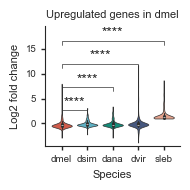

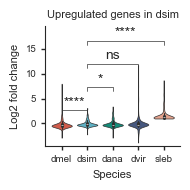

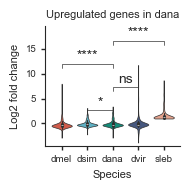

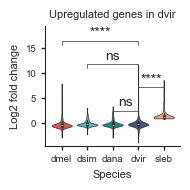

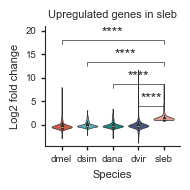

In [106]:
plot_upregulated_genes(gene_shared_all_1, species_list)

In [110]:
def plot_upregulated_genes(gene_shared_all_1, species_list, species):
    cat_list = ['dmel_cat','dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']
    species_cat = f'{species}_cat'
    species_cat_left = cat_list.remove(species_cat)

    df_long = upregulated[species][['dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].melt(var_name="species", value_name="Category")

    df_long['species'] = df_long['species'].str.replace('_cat', '', regex=False)

    # Count occurrences of each category per species
    df_counts = df_long.value_counts(["species", "Category"]).reset_index(name="Count")

    species_order = species_list.copy()
    species_order.remove(species)
    

    # Plot stacked bar chart
    plt.figure(figsize=(2, 2))
    ax = sns.barplot(data=df_counts, x="species", y="Count", hue="Category", order=species_order, dodge=False, palette=npg_palette2[:3])

    plt.xlabel("")
    plt.ylabel("Count", fontsize=8)
    plt.title("Upregulated genes in dmel", fontsize=8)
    ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Category", fontsize=7, title_fontsize=8, markerscale=0.8, 
                    frameon=False)
    sns.despine()

    #plt.show()
    #plt.savefig("upregulated_dmel_cat_others.svg", dpi=300)#, bbox_inches='tight')

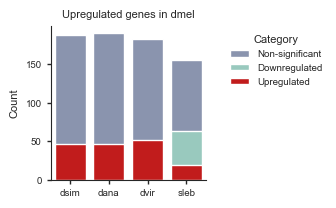

In [111]:
plot_upregulated_genes(gene_shared_all_1, species_list, species='dmel')

In [109]:
def find_matching_rows(gene_id):
    return groups[groups['group'].str.contains(gene_id, regex=False)]

# Apply function for each ID in df1
merged_df = dmel_up_all.apply(lambda row: find_matching_rows(row['gene']).assign(ID=row['gene']), axis=1)

# Flatten the resulting list of DataFrames
merged_df = pd.concat(merged_df.tolist(), ignore_index=True)

NameError: name 'dmel_up_all' is not defined

In [82]:
merged_df['n_species'] = merged_df['species'].str.count(',') + 1

In [129]:
df_counts = merged_df['n_species'].value_counts().reset_index()
df_counts.columns = ['n_species', 'count']  

# Plot distribution of value counts
plt.figure(figsize=(2, 2))
ax = sns.barplot(data=df_counts, x='n_species', y='count', hue='n_species', palette=npg_palette2, legend=False)

# Customizing labels and appearance
plt.xlabel("Number of species", fontsize=8)
plt.ylabel("Counts", fontsize=8)
plt.title("Number of species sharing upregulated genes in dmel", fontsize=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)

sns.despine()  # Remove top and right spines
#plt.show()
#plt.savefig("upregulated_dmel_no_species.svg", dpi=300)

NameError: name 'merged_df' is not defined

In [ ]:
def find_matching_rows(gene_id):
    return df2[df2['Gene_List'].str.contains(gene_id, regex=False)]

# Apply function for each ID in df1
merged_df = df1.apply(lambda row: find_matching_rows(row['ID']).assign(ID=row['ID']), axis=1)

# Flatten the resulting list of DataFrames
merged_df = pd.concat(merged_df.tolist(), ignore_index=True)

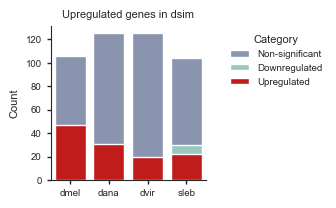

In [96]:
df_long = upregulated['dsim'][['dmel_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].melt(var_name="species", value_name="Category")

df_long['species'] = df_long['species'].str.replace('_cat', '', regex=False)

# Count occurrences of each category per species
df_counts = df_long.value_counts(["species", "Category"]).reset_index(name="Count")

species_order = species_list.copy()
species_order.remove('dsim')

category_order = ['Non-significant', 'Downregulated', 'Upregulated']

# Convert the 'Category' column to a categorical type with the specified order
df_counts['Category'] = pd.Categorical(df_counts['Category'], categories=category_order, ordered=True)

# Plot stacked bar chart
plt.figure(figsize=(2, 2))
ax = sns.barplot(data=df_counts, x="species", y="Count", hue="Category", order=species_order, hue_order=category_order, 
                 dodge=False, palette=npg_palette2[:3])

plt.xlabel("")
plt.ylabel("Count", fontsize=8)
plt.title("Upregulated genes in dsim", fontsize=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Category", fontsize=7, title_fontsize=8, markerscale=0.8, 
                frameon=False)
sns.despine()

# Show plot
plt.show()

In [112]:
# plot upset plot for expression conservation across species
def species_counts_shared_expression(gene_shared_all_1):
    # List of category columns for each species
    cat_columns = ['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']

    # Create a new column with a list of species where the value is "Upregulated"
    gene_shared_all_1['upregulated_species'] = gene_shared_all_1.apply(
        lambda row: ", ".join([species for species in species_list if row[f'{species}_cat'] == 'Upregulated']), 
        axis=1
    )

    species_ex_counts = gene_shared_all_1['upregulated_species'].value_counts()
    species_ex_dict = {tuple(k.split(', ')): v for k, v in species_ex_counts.items() if k!=""}

    membership_ex_list = [list(k) for k in species_ex_dict.keys()]
    count_ex_values = list(species_ex_dict.values())

    upset_ex = from_memberships(membership_ex_list, data=count_ex_values)

    # reorder the categories so that they appear in the correct order
    column_order = ["dmel", "dsim", "dana", "dvir", "sleb"]
    upset_ex = upset_ex.reorder_levels(column_order).sort_index()

    fig = plt.figure(figsize=(3, 3)) # set size of the figure
    plot_result_ex = plot(upset_ex, fig=fig, element_size=10, sort_by='cardinality', sort_categories_by='-input') # plot and sort the categories
    plt.suptitle("Conservation of upregulated genes across species", size=8) # add title

    # the upset plot is consists of 3 parts: intersections, matrix and totals.
    plot_result_ex["intersections"].set_ylabel("Count", fontsize=8)
    plot_result_ex["intersections"].set_ylim(0, 400) 
    plot_result_ex["intersections"].tick_params(labelsize=7)
    plot_result_ex["totals"].set_xlabel("Genes in species", size=8)
    plot_result_ex["matrix"].tick_params(axis='y', labelsize=7)
    plot_result_ex["totals"].tick_params(labelsize=7, width=1, length=3)

    #plt.show()
    #plt.savefig("species_expression_ef_0424.svg", dpi=300)

/Users/cong/opt/anaconda3/envs/research_py39/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/cong/opt/anaconda3/envs/research_py39/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

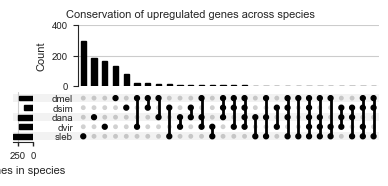

In [113]:
species_counts_shared_expression(gene_shared_all_1)